# 目标① 建立上海某共享单车的使用时间分布模型

第一次运行，可以运行pip install, 以后可以注释掉这一句

In [1]:
#pip install transbigdata keplergl scikit-learn statsmodels folium

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import pandas as pd 
import utilization as util
import geopandas as gpd
import transbigdata as tbd
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import numpy as np

from matplotlib import colormaps
from statsmodels.tsa.statespace.sarimax import SARIMAX

# matplotlib相关chart的字体为中文
plt.rcParams['font.sans-serif'] = ['FangSong']


### Read Data

In [4]:
#Read bicycle sharing data
bikedata = pd.read_csv(r'data/上海某共享单车数据集.csv')

bikedata['start_time'] = bikedata['start_time'].astype('datetime64[s]')
bikedata['end_time'] = bikedata['end_time'].astype('datetime64[s]')
bikedata['bikeid'] = bikedata['bikeid'].astype('string')
bikedata['orderid'] = bikedata['orderid'].astype('string')
bikedata['userid'] = bikedata['userid'].astype('string')

bikedata.head(5)

,orderid,bikeid,userid,start_time,start_location_x,start_location_y,end_time,end_location_x,end_location_y,track,start_year,start_month,start_day,start_weekday,start_hour,weekend,DistanceBtwStartEnd
0,31355,79699,759,2023-07-01 00:23:00,121.520,31.309,2023-07-01 00:32:00,121.525,31.316,"121.520,31.309#121.521,31.309#121.522,31.309#1...",2023,7,1,Saturday,0,0,0.910441
1,31388,33279,1440,2023-07-01 00:25:00,121.505,31.294,2023-07-01 00:40:00,121.517,31.309,"121.504,31.295#121.504,31.296#121.505,31.294#1...",2023,7,1,Saturday,0,0,2.017700
2,31401,3060,5463,2023-07-01 00:26:00,121.375,31.107,2023-07-01 00:41:00,121.387,31.103,"121.375,31.107#121.376,31.107#121.376,31.108#1...",2023,7,1,Saturday,0,0,1.227693
3,31423,43119,4666,2023-07-01 00:32:00,121.528,31.263,2023-07-01 00:52:00,121.531,31.282,"121.527,31.265#121.527,31.266#121.528,31.263#1...",2023,7,1,Saturday,0,0,2.125893
4,31438,116238,2193,2023-07-01 00:33:00,121.434,31.249,2023-07-01 00:46:00,121.427,31.260,"121.427,31.260#121.428,31.259#121.428,31.260#1...",2023,7,1,Saturday,0,0,1.389966


### Data Cleaning

In [5]:
# Shanghai bounds
bounds = [121.173, 30.842, 121.97, 31.45]
sh = gpd.read_file(f'data/shanghai.geojson')
lines_before = len(bikedata)
#delete the data outside of the study area
bikedata = tbd.clean_outofshape(bikedata,sh,col=['start_location_x','start_location_y'], accuracy=500)
lines_after = len(bikedata)
print('after data clean, the items is changed from {} to {}'.format(lines_before, lines_after))

bikedata.head(5)

after data clean, the items is changed from 102361 to 102361


,orderid,bikeid,userid,start_time,start_location_x,start_location_y,end_time,end_location_x,end_location_y,track,start_year,start_month,start_day,start_weekday,start_hour,weekend,DistanceBtwStartEnd
0,31355,79699,759,2023-07-01 00:23:00,121.520,31.309,2023-07-01 00:32:00,121.525,31.316,"121.520,31.309#121.521,31.309#121.522,31.309#1...",2023,7,1,Saturday,0,0,0.910441
1,31645,78767,6378,2023-07-01 01:21:00,121.518,31.310,2023-07-01 01:24:00,121.513,31.311,"121.514,31.311#121.515,31.310#121.515,31.311#1...",2023,7,1,Saturday,1,0,0.488710
2,47126,123667,4459,2023-07-01 06:02:00,121.518,31.308,2023-07-01 06:25:00,121.484,31.304,"121.484,31.304#121.484,31.305#121.484,31.306#1...",2023,7,1,Saturday,6,0,3.266973
3,47199,107608,4123,2023-07-01 06:14:00,121.521,31.309,2023-07-01 06:21:00,121.531,31.306,"121.521,31.309#121.522,31.309#121.523,31.309#1...",2023,7,1,Saturday,6,0,1.008402
4,683941,134252,2578,2023-07-02 22:18:00,121.521,31.308,2023-07-02 22:36:00,121.495,31.316,"121.495,31.313#121.495,31.314#121.495,31.315#1...",2023,7,2,Sunday,22,0,2.629133


### Get Data of move data
In reference, the logic is as below
```
move_data,stop_data = tbd.bikedata_to_od(bikedata,
                   col = ['BIKE_ID','DATA_TIME','LONGITUDE','LATITUDE','LOCK_STATUS'])
move_data.head(5)
```
Method `bikedata_to_od` is from the dataset includes below columns:
```
['BIKE_ID', 'DATA_TIME', 'LONGITUDE',
                        'LATITUDE', 'LOCK_STATUS']
```
It is original data of sharing bicycles.
In our data, it is already just move data after converted.
We can use it directly. to make it easy to copy the code , the column name is updated

In [6]:
move_data = bikedata.rename(
    columns={
        'start_time':'stime',
        'start_location_x':'slon',
        'start_location_y':'slat',
        'end_time':'etime',
        'end_location_x':'elon',
        'end_location_y':'elat'
    }
)
move_data[['orderid','bikeid']] = bikedata[['orderid','bikeid']]

#original distance is kilometer, it is too big
#change it to meter
move_data['distance'] = 1000 * bikedata['DistanceBtwStartEnd']

#process date time to other dimension to process
move_data['date'] = pd.to_datetime(move_data['stime']).dt.date
move_data['hour'] = pd.to_datetime(move_data['stime']).dt.hour
move_data['weekday'] = pd.to_datetime(move_data['stime']).dt.day_of_week
map_obj = {0:'0-星期日',1:'1-星期一',2:'2-星期二',3:'3-星期三',4:'4-星期四',5:'5-星期五',6:'6-星期六'}
move_data['weekday'] = move_data['weekday'].map(map_obj)

move_data.head(5)

,orderid,bikeid,userid,stime,slon,slat,etime,elon,elat,track,...,start_month,start_day,start_weekday,start_hour,weekend,DistanceBtwStartEnd,distance,date,hour,weekday
0,31355,79699,759,2023-07-01 00:23:00,121.520,31.309,2023-07-01 00:32:00,121.525,31.316,"121.520,31.309#121.521,31.309#121.522,31.309#1...",...,7,1,Saturday,0,0,0.910441,910.441354,2023-07-01,0,5-星期五
1,31645,78767,6378,2023-07-01 01:21:00,121.518,31.310,2023-07-01 01:24:00,121.513,31.311,"121.514,31.311#121.515,31.310#121.515,31.311#1...",...,7,1,Saturday,1,0,0.488710,488.710408,2023-07-01,1,5-星期五
2,47126,123667,4459,2023-07-01 06:02:00,121.518,31.308,2023-07-01 06:25:00,121.484,31.304,"121.484,31.304#121.484,31.305#121.484,31.306#1...",...,7,1,Saturday,6,0,3.266973,3266.972791,2023-07-01,6,5-星期五
3,47199,107608,4123,2023-07-01 06:14:00,121.521,31.309,2023-07-01 06:21:00,121.531,31.306,"121.521,31.309#121.522,31.309#121.523,31.309#1...",...,7,1,Saturday,6,0,1.008402,1008.402155,2023-07-01,6,5-星期五
4,683941,134252,2578,2023-07-02 22:18:00,121.521,31.308,2023-07-02 22:36:00,121.495,31.316,"121.495,31.313#121.495,31.314#121.495,31.315#1...",...,7,2,Sunday,22,0,2.629133,2629.132856,2023-07-02,22,6-星期六


If the disctance is too long or too short it is not normal data, delete them.

In [7]:
#Remove too long and too short trips
print('length before {}'.format(len(move_data.index)))
move_data = move_data[(move_data['distance']>100)&(move_data['distance']<10000)]
print('after remove too long and too short trips, length after {}'.format(len(move_data.index)))

length before 102361
after remove too long and too short trips, length after 102047


In [8]:
df_tmp = pd.pivot_table(move_data,values='orderid',index=['date','hour','weekday'],aggfunc='count')
df_tmp = df_tmp.reset_index()
df_tmp.head(5)

,date,hour,weekday,orderid
0,2023-07-01,0,5-星期五,13
1,2023-07-01,1,5-星期五,14
2,2023-07-01,2,5-星期五,7
3,2023-07-01,3,5-星期五,4
4,2023-07-01,4,5-星期五,3


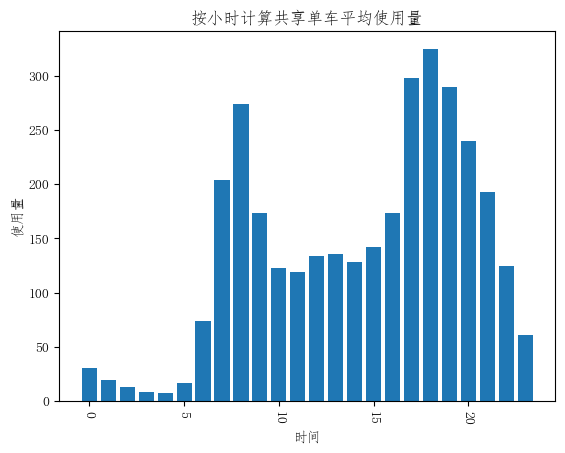

In [9]:
df_hour = pd.pivot_table(df_tmp,values='orderid',index=['hour'],aggfunc='mean')
df_hour = df_hour.reset_index()

plt.bar(df_hour['hour'],df_hour['orderid'])
plt.xticks(rotation=270)
plt.title('按小时计算共享单车平均使用量')
plt.xlabel('时间')
plt.ylabel('使用量')
plt.show()


从这个图看来，共享单车使用的高峰时间是早上8点和下午17/18/19点。可以看到主要的使用量是和工作或者上学有关的。估计也会和星期相关

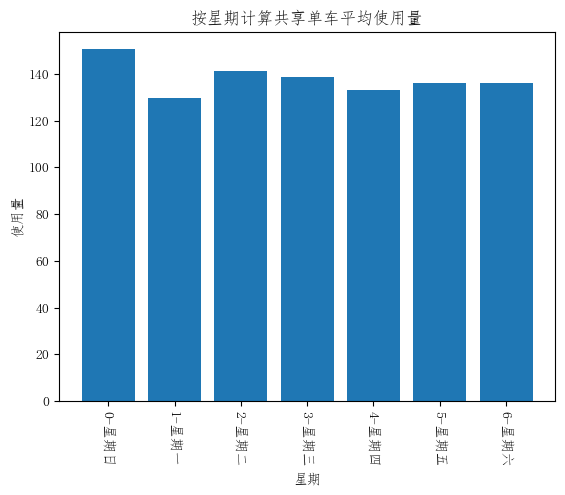

In [10]:
df_weekday = pd.pivot_table(df_tmp,values='orderid',index=['weekday'],aggfunc='mean')
df_weekday = df_weekday.reset_index()

plt.bar(df_weekday['weekday'],df_weekday['orderid'])
plt.xticks(rotation=270)

plt.title('按星期计算共享单车平均使用量')
plt.xlabel('星期')
plt.ylabel('使用量')
plt.show()

从这个图可以看到，共享单车的使用量有周期性，和星期有关。星期日的量比较小

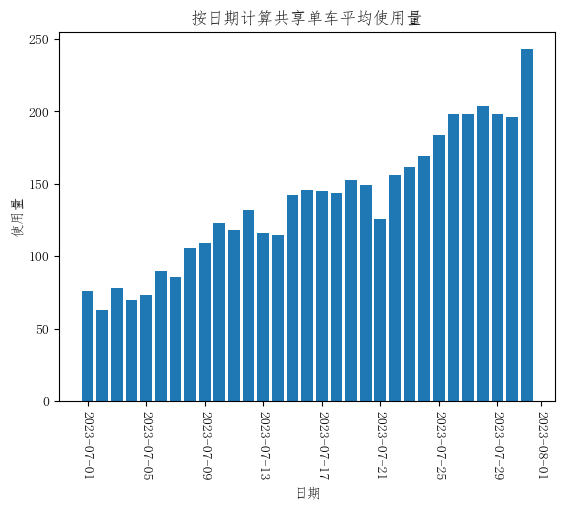

In [11]:
df_date = pd.pivot_table(df_tmp,values='orderid',index=['date'],aggfunc='mean')
df_date = df_date.rename(columns={'orderid':'count'})
df_date['count'] = df_date['count'].astype('int')
df_date = df_date.reset_index()

plt.bar(df_date['date'],df_date['count'])
plt.xticks(rotation=270)

plt.title('按日期计算共享单车平均使用量')
plt.xlabel('日期')
plt.ylabel('使用量')
plt.show()

从这个图看来，共享单车的使用量，同时有和星期相关的同期性，又有趋势性。
考虑到7月份下半月相对温度较低，检查共享单车使用量是否和气温有关。

以下上海天气数据来自于TuTiempo.net

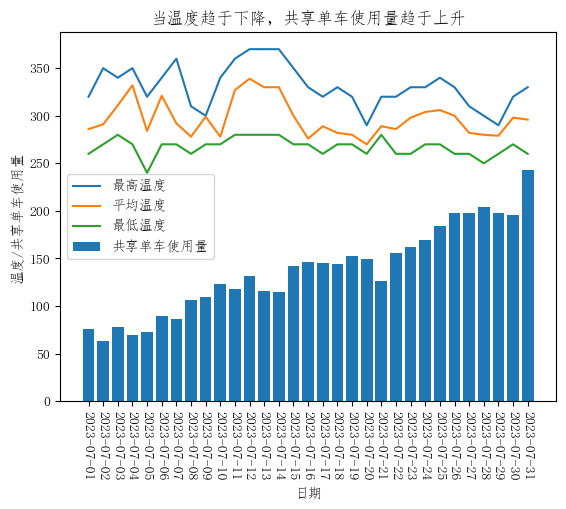

In [12]:
df_weather = pd.read_csv('./data/Shanghai_Weather.csv')
df_date = df_date.rename(columns={'date':'Date','count':'Count'})
df_date['Date'] = df_date['Date'].astype('string')
df_weather['Date'] = df_weather['Date'].astype('string')
df_date_with_temperature = pd.merge(df_date,df_weather,on=['Date'])

df_date_with_temperature = df_date_with_temperature.rename(columns={'Count':'BikeCount','Min_Temp_x':'Min_Temp','Max_Temp_x':'Max_Temp'})
df_date_with_temperature['Max_Temp'] = df_date_with_temperature['Max_Temp'] * 10
df_date_with_temperature['Min_Temp'] = df_date_with_temperature['Min_Temp'] * 10
df_date_with_temperature['Avg_Temp'] = df_date_with_temperature['Avg_Temp'] * 10

plt.bar(df_date_with_temperature['Date'],df_date_with_temperature['BikeCount'],label='共享单车使用量')
plt.plot(df_date_with_temperature['Date'],df_date_with_temperature['Max_Temp'],label='最高温度')
plt.plot(df_date_with_temperature['Date'],df_date_with_temperature['Avg_Temp'],label='平均温度')
plt.plot(df_date_with_temperature['Date'],df_date_with_temperature['Min_Temp'],label='最低温度')

plt.legend()

plt.xticks(rotation=270)

plt.title('当温度趋于下降，共享单车使用量趋于上升')
plt.xlabel('日期')
plt.ylabel('温度/共享单车使用量')
plt.show()


从这个图，可以看出，共享单车使用量是和天气相关的。考虑到使用高峰的时间，早上8点和下午16/17/18点和凌晨4点的最低温度和下午2点的最高温度的关系比较弱，我们可以看到平均气温更加和共享单车使用量相关。

综上计算，我们发现共享单车的使用量既有周期性，又有和外生变量当天平均气温的相关性。

所以，我们预设共享单车使用量的模型如下：
考虑到人体最舒服温度是25度，假设距离25度越远，人的感觉越不舒服，使用共享单车的意愿越低。

Temp_adj = abs( Average Temp - 25 )
Usage_Exp = a * Temp_adj + b  ( 一元线性回归)
Usage = Usage_Exp + 季节性ARIMA( Usage ) + 残差

31天的数据，用1 ~ 24日的数据，计算模型参数
用25~31日的数据，测试模型计算结果

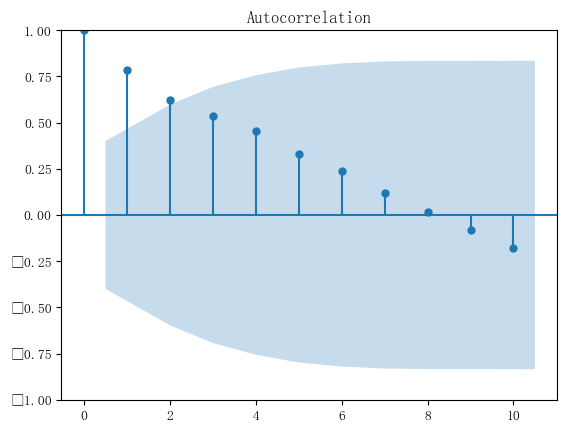

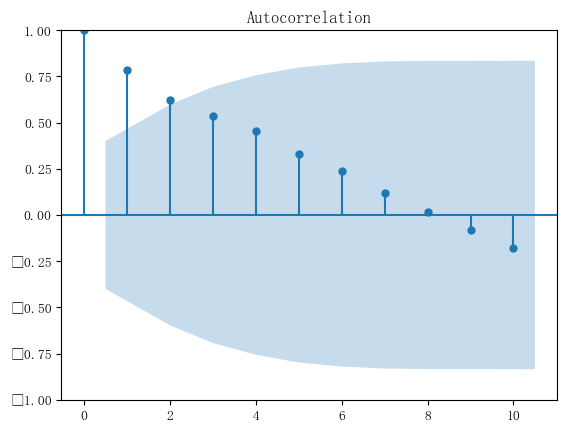

In [13]:
# Forecast

df_date_with_temperature['Temp_adj'] = df_date_with_temperature['Avg_Temp'] - 25 * 10
df_date_with_temperature['Temp_adj'] = df_date_with_temperature['Temp_adj'].abs()
df_train = df_date_with_temperature.head(24)
df_test = df_date_with_temperature.tail(7)

# 创建一个线性回归模型
model = LinearRegression()

# 用x列来预测y列
model.fit(df_train['Temp_adj'].values.reshape(-1,1), df_train['BikeCount'].values.reshape(-1,1))

coef = model.coef_
Intercept = model.intercept_

df_train['Usage_Exp'] = coef[0] * df_train['Temp_adj'] + Intercept[0]
df_train['Diff'] = df_train['BikeCount'] - df_train['Usage_Exp']

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
acf = plot_acf(df_train['Diff'], lags=10)
acf

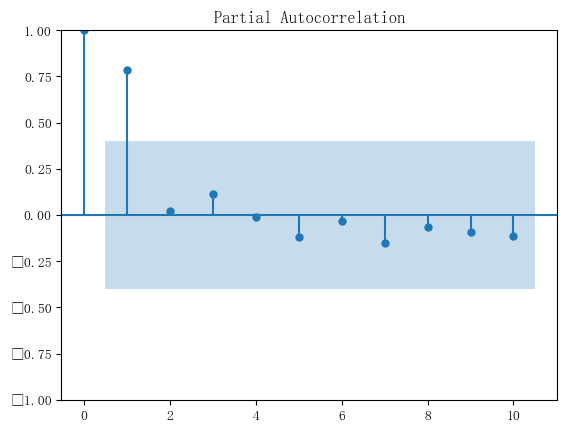

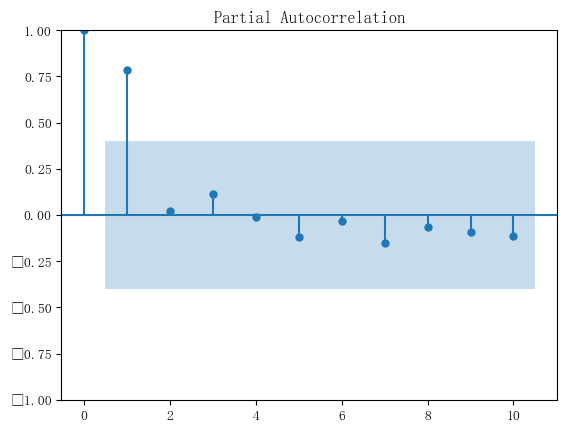

In [14]:
plot_pacf(df_train['Diff'], lags=10)

c:\ProgramData\anaconda3\envs\transbigdata\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


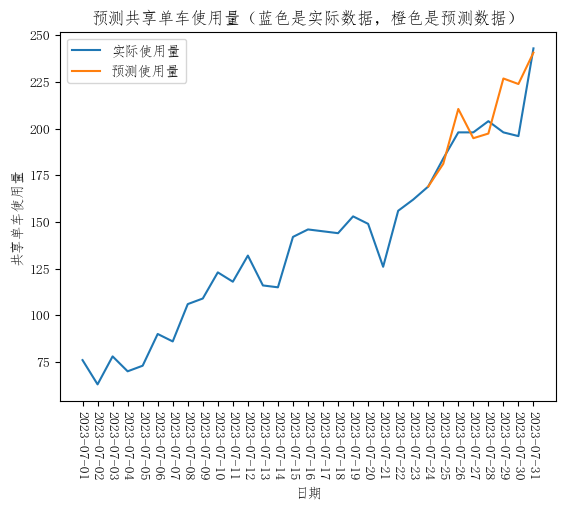

array([136.01448341])

In [15]:

# Predict Linear result as Usage Exp
df_test['Usage_Exp'] = model.predict(df_test['Temp_adj'].values.reshape(-1,1))

# Predict Seaonal Factor from Diff by Seasonal ARIMA
# Seasonal is from 7, one week has 7 days
# as acf there are 3个显著变大, p = 3
# as pacf there is 3个显著变大，q = 2
# d 是差分的介数，取1，得到以下参数
model = SARIMAX(df_train['Diff'], order=(3, 2, 1), seasonal_order=(1, 1, 1, 7))
model_fit = model.fit()

# Predict
df_test['Diff'] = model_fit.predict(start=24, end=31, dynamic=False)


df_test['predict'] = df_test['Diff'] + df_test['Usage_Exp']


df_date_with_temperature['predict_bike_count'] = df_date_with_temperature['BikeCount']

df_date_with_temperature['Usage_Exp'] = 0
df_date_with_temperature.loc[range(24),'Usage_Exp'] = np.array(df_train['Usage_Exp'])
df_date_with_temperature.loc[range(24,31),'Usage_Exp'] = np.array(df_test['Usage_Exp'])
df_date_with_temperature.loc[range(24,31),'predict_bike_count'] = np.array(df_test['predict'])
df_date_with_temperature = df_date_with_temperature[['Date','BikeCount','Avg_Temp','Temp_adj','Usage_Exp','predict_bike_count']]

df_date_with_temperature['diff'] = 0
df_date_with_temperature.loc[range(24),'diff'] = df_train['Diff']
df_date_with_temperature.loc[range(24,31),'diff'] = df_test['Diff']
df_date_with_temperature = df_date_with_temperature.take([
    0,1,2,3,4,6,5
],axis=1)

plt.plot(df_date_with_temperature['Date'],df_date_with_temperature['BikeCount'],label='实际使用量')
plt.plot(df_date_with_temperature.tail(8)['Date'],df_date_with_temperature.tail(8)['predict_bike_count'],label='预测使用量')

plt.title('预测共享单车使用量（蓝色是实际数据，橙色是预测数据）')
plt.xlabel('日期')
plt.ylabel('共享单车使用量')
plt.legend(loc='best')

plt.xticks(rotation=270)
plt.show()

预测在24日进行，来预测25~31日的自行车使用量。预测是比较准确的

In [16]:
#column Temp_Adjust is (Average_Temperature - 25 )'s 绝对值'
#column usage_exp is from Linear Regression with temperature ( Temp_Adjust)
#column diff is from ARIMA model
# column predict_bike_count is from sum of (diff and usage_exp)

df_date_with_temperature

,Date,BikeCount,Avg_Temp,Temp_adj,Usage_Exp,diff,predict_bike_count
0,2023-07-01,76,286.0,36.0,123.194933,-47.194933,76.000000
1,2023-07-02,63,291.0,41.0,121.414439,-58.414439,63.000000
2,2023-07-03,78,311.0,61.0,114.292467,-36.292467,78.000000
3,2023-07-04,70,332.0,82.0,106.814395,-36.814395,70.000000
4,2023-07-05,73,284.0,34.0,123.907130,-50.907130,73.000000
5,2023-07-06,90,321.0,71.0,110.731480,-20.731480,90.000000
6,2023-07-07,86,292.0,42.0,121.058341,-35.058341,86.000000
7,2023-07-08,106,278.0,28.0,126.043722,-20.043722,106.000000
8,2023-07-09,109,299.0,49.0,118.565650,-9.565650,109.000000
9,2023-07-10,123,278.0,28.0,126.043722,-3.043722,123.000000


# 目标②：建立上海某共享单车的需求模型
假设每天凌晨调整共享单车的位置。依据是前一天的自行车净增加，和净减少
假设在2023-07-29的凌晨开始调整自行车位置。以下对2023-07-28全天的分析，可以用来决定如何调整自行车的运输

In [17]:
## 从第三部分分析，可以看出，共享单车最重试使用的区域，是杨浦和虹口
## 所以我们就从两个区研究

# 选择一天来统计 2023-07-28, 这一天可以修改
move_data_sample = move_data[move_data['stime'].between('2023-07-28 00:00:00','2023-07-29 00:00:00')]
# 杨浦区
move_data_sample_yp = tbd.clean_outofshape(move_data_sample,gpd.read_file(r'./data/杨浦区.json'),col=['slon','slat'], accuracy=500)
# 虹口区
move_data_sample_hk = tbd.clean_outofshape(move_data_sample,gpd.read_file(r'./data/虹口区.json'),col=['slon','slat'], accuracy=500)

# 合并两个区的数据
move_data_sample_sum = pd.concat([move_data_sample_yp,move_data_sample_hk],ignore_index=True,axis=0)
move_data_sample = move_data_sample_sum.drop_duplicates()

# 栅格化
params = tbd.area_to_params(bounds,accuracy = 500)
od_gdf_sample =  tbd.odagg_grid(move_data_sample, params, col=['slon', 'slat', 'elon', 'elat'])

df_sample_o = od_gdf_sample[['SLONCOL','SLATCOL','count']]
# 如果自行车离开这个grid，取正数
df_sample_o['count'] = df_sample_o['count']
df_sample_o = df_sample_o.rename(columns={'SLONCOL':"LONCOL",'SLATCOL':'LATCOL'})

df_sample_i = od_gdf_sample[['ELONCOL','ELATCOL','count']]
# 如果自行车到达这个grid，取正数
df_sample_i['count'] = df_sample_i['count']
df_sample_i = df_sample_i.rename(columns={'ELONCOL':"LONCOL",'ELATCOL':'LATCOL'})

df_sample = pd.concat([df_sample_i,df_sample_o],ignore_index=True)
df_sample = pd.pivot_table(df_sample,values='count',aggfunc='sum',index=['LONCOL','LATCOL'])
df_sample = df_sample.reset_index()

df_sample['count'] = df_sample['count']
center = tbd.grid_to_centre([df_sample['LONCOL'],df_sample['LATCOL']],params)
df_sample['HBLON'] = center[0]
df_sample['HBLAT'] = center[1]

# 初始化tbd
util.initial_trans_big_data()

# display at end of 2023-07-28, the requirements of bikes 
kepler_gl = tbd.visualization_data(df_sample,['HBLON','HBLAT','count'])
kepler_gl.add_data(sh,'district')
kepler_gl

PermissionError: [Errno 13] Permission denied: 'c:\\ProgramData\\anaconda3\\envs\\transbigdata\\Lib\\site-packages\\transbigdata\\config.ini'

In [ ]:
# 栅格化
params = tbd.area_to_params(bounds,accuracy = 500)
od_gdf_sample =  tbd.odagg_grid(move_data_sample, params, col=['slon', 'slat', 'elon', 'elat'])

df_sample_o = od_gdf_sample[['SLONCOL','SLATCOL','count']]
# 如果自行车离开这个grid，取负数
df_sample_o['count'] = 0 - df_sample_o['count']
df_sample_o = df_sample_o.rename(columns={'SLONCOL':"LONCOL",'SLATCOL':'LATCOL'})

df_sample_i = od_gdf_sample[['ELONCOL','ELATCOL','count']]
# 如果自行车到达这个grid，取正数
df_sample_i['count'] = df_sample_i['count']
df_sample_i = df_sample_i.rename(columns={'ELONCOL':"LONCOL",'ELATCOL':'LATCOL'})

df_sample = pd.concat([df_sample_i,df_sample_o],ignore_index=True)
df_sample = pd.pivot_table(df_sample,values='count',aggfunc='sum',index=['LONCOL','LATCOL'])
df_sample = df_sample.reset_index()

# Count < 0 表示 grid中更多的bike离开，表示需要投入
df_sample_req = df_sample[df_sample['count'] < 0] 

df_sample_req['count'] = 0 - df_sample_req['count']
center = tbd.grid_to_centre([df_sample_req['LONCOL'],df_sample_req['LATCOL']],params)
df_sample_req['HBLON'] = center[0]
df_sample_req['HBLAT'] = center[1]

# display at end of 2023-07-28, the requirements of bikes 
kepler_gl = tbd.visualization_data(df_sample_req,['HBLON','HBLAT','count'])
kepler_gl.add_data(sh,'district')
kepler_gl

In [ ]:
# Count < 0 表示 grid中更多的bike离开，表示需要投入
df_sample_supply = df_sample[df_sample['count'] > 0] 

center = tbd.grid_to_centre([df_sample_supply['LONCOL'],df_sample_supply['LATCOL']],params)
df_sample_supply['HBLON'] = center[0]
df_sample_supply['HBLAT'] = center[1]

# display at end of 2023-07-28, the supply of bikes 
kepler_gl = tbd.visualization_data(df_sample_supply,['HBLON','HBLAT','count'])
kepler_gl.add_data(sh,'district')
kepler_gl

In [ ]:
# 考虑到百度地图在规划路线时候，最多有10个中间点，所以对于count较小的点，先删除
df_sample_supply = df_sample_supply.sort_values('count',ascending=False).head(10)
df_sample_req = df_sample_req.sort_values('count',ascending=False).head(10)

#假设卡车从西南角出发，经过10个点，到东北角，然后把各个点的车放到卡车上。
#然后从东北角出发，经过10个点，回到原来的西南角

df_tmp = pd.concat([df_sample_supply,df_sample_req],ignore_index=True)
start = df_tmp.agg({'HBLON':'max','HBLAT':'max'})
start = "{},{}".format(start['HBLAT'] , start['HBLON'])
start

In [ ]:
end = df_tmp.agg({'HBLON':'min','HBLAT':'min'})
end = '{},{}'.format(end['HBLAT'], end['HBLON']) 
end

In [ ]:
df_sample_req['Baidu'] = df_sample_req['HBLAT'].astype('str') + ',' + df_sample_req['HBLON'].astype('str')
df_sample_supply['Baidu'] = df_sample_supply['HBLAT'].astype('str') + ',' + df_sample_supply['HBLON'].astype('str')
df_sample_supply['Baidu'].values
df_sample_supply


In [ ]:
supply_path_data = util.get_routes(
  start,
  end ,
  df_sample_supply['Baidu'].values,
  "2023-07-25T02:00:00"
) 


request_path_data = util.get_routes(
  end,
  start ,
  df_sample_req['Baidu'].values,
  "2023-07-25T03:00:00"
) 


In [ ]:
import folium

tiles= 'https://wprd01.is.autonavi.com/appmaptile?x={x}&y={y}&z={z}&lang=zh_cn&size=1&scl=1&style=7'
map = folium.Map([31.24149,121.49203],
               tiles=tiles ,
               attr='高德-常规图',
               zoom_start=11,
               control_scale=True,
               width='70%'
              )

for idx in df_sample_supply.index:
    folium.Marker([float(df_sample_supply.loc[idx,'HBLAT']),
                   float(df_sample_supply.loc[idx,'HBLON'])
                  ], popup='Supply: {}'.format(df_sample_supply.loc[idx,'count']),
                  icon=folium.Icon(color="green", icon="ok-sign")
                 ).add_to(map)
    
for idx in df_sample_req.index:
    folium.Marker([float(df_sample_req.loc[idx,'HBLAT']),
                   float(df_sample_req.loc[idx,'HBLON'])
                  ], popup='Request: {}'.format(df_sample_req.loc[idx,'count']),
                  icon=folium.Icon(color="blue", icon="ok-sign")
                 ).add_to(map)
# 添加路线

df_path = pd.DataFrame(supply_path_data[0]['steps']+request_path_data[0]['steps'])

for idx in df_path.index:
    folium.PolyLine([
        [float(df_path.loc[idx,'start_location']['lat']), 
         float(df_path.loc[idx,'start_location']['lng'])
        ],  # 起点
        [float(df_path.loc[idx,'end_location']['lat']), 
         float(df_path.loc[idx,'end_location']['lng'])]   # 终点
    ], color='blue', weight=5).add_to(map)

map

In [ ]:
import json
df_move_by_truck = pd.DataFrame(
    supply_path_data[0]['steps'] + request_path_data[0]['steps']
)
df_move_by_truck['truckid'] = 'dummy_truck'
df_move_by_truck['init_time'] = "2023-07-25 00:00:00"
df_move_by_truck['init_time'] = df_move_by_truck['init_time'].astype('datetime64[s]')
df_move_by_truck['duration'] = df_move_by_truck['duration'].astype('float')


sum_list = []

for idx in df_move_by_truck.index:
    sum = int(df_move_by_truck.loc[range(int(idx)+1),'duration'].sum())
    sum_list = sum_list + [sum]

df_move_by_truck['dur_sum'] = sum_list
df_move_by_truck['time'] = df_move_by_truck['init_time'] + pd.to_timedelta(df_move_by_truck['dur_sum'], unit='s')
df_move_by_truck = df_move_by_truck[["init_time","start_location","end_location","truckid","time"]]

# 

obj = {}
obj['time'] = df_move_by_truck.loc[0,'init_time']
obj['lon'] = df_move_by_truck.loc[0,'start_location']['lng']
obj['lat'] = df_move_by_truck.loc[0,'start_location']['lat']
obj['truckid'] = 'ABC1234567789'
list = [obj]

for idx in df_move_by_truck.index:
    obj = {}
    obj['time'] = df_move_by_truck.loc[idx,'time']
    obj['lon'] = df_move_by_truck.loc[idx,'end_location']['lng']
    obj['lat'] = df_move_by_truck.loc[idx,'end_location']['lat']
    obj['truckid'] = 'ABC1234567789'
    list = list + [obj]

df_list = pd.DataFrame(list)
df_list['time'] = df_list['time'].astype('datetime64[s]')
df_list['lon'] = df_list['lon'].astype('float64')
df_list['lat'] = df_list['lat'].astype('float64')
df_list = df_list.head(441)
util.initial_trans_big_data()
kepler_gl = tbd.visualization_trip(df_list.head(441),col=['lon','lat','truckid','time'])
kepler_gl.add_data(df_sample_supply,'supply')
kepler_gl.add_data(df_sample_req,'request')
kepler_gl.add_data(sh,'district')

kepler_config_file = open('./data/trip_config.json','r')
kepler_config = json.load(kepler_config_file)
kepler_gl.config = kepler_config
kepler_gl

# 目标③：提供城市交通拥堵情况的参考

### Make the data into Grid
The method tbd.**odagg_grid** should be noticed. As it is OD data

In [ ]:

# 栅格化
params = tbd.area_to_params(bounds,accuracy = 500)
#aggregate the travel informations
od_gdf = tbd.odagg_grid(move_data, params, col=['slon', 'slat', 'elon', 'elat'])
od_gdf.head(5)

### Draw the OD Diagram

In [ ]:
#Create figure
import matplotlib.pyplot as plt
fig =plt.figure(1,(8,8),dpi=300)
ax =plt.subplot(111)
plt.sca(ax)

#Load basemap
tbd.plot_map(plt,bounds,zoom = 11,style = 8)

#Create colorbar
cax = plt.axes([0.05, 0.33, 0.02, 0.3])

plt.title('共享单车使用量')
plt.ylabel('位置')
plt.sca(ax)

#Plot OD only check the points with big counts
od_gdf.plot(ax = ax,column = 'count',cmap = 'Blues_r',linewidth = 0.5,vmax = 10,cax = cax,legend = True)

#Plot compass and scale
tbd.plotscale(ax,bounds = bounds,textsize = 10,compasssize = 1,textcolor = 'white',accuracy = 2000,rect = [0.06,0.03],zorder = 10)
plt.axis('off')
plt.xlim(bounds[0],bounds[2])
plt.ylim(bounds[1],bounds[3])
plt.show()

从上图可以看到，浦东的共享单车使用比较少。最多的是杨浦，虹口等比较老的地区。

原因推测：
1、浦东比较新，路比较宽，建筑物之前的距离比较远。用汽车更加方便，很多时间共享单车需要骑行远，比较辛苦
2、类似杨浦，虹口等老城区，路比较狭窄，对于汽车相关没有那么友好。同时建筑物比较密集，到达目标相对比较近，用共享单车比较容易。
3、类似杨浦，虹口这样的老城区，大学比较密集。在大学校园那么大地方，走路有点累，汽车又不容易开。用共享单车比较多。
4、新的大学区，比如松江大学城，奉贤大学城等，没有发现大量使用共享单车。应该是新的大学城在规划上比较好的考虑了交通的问题。

所以，和共享单车使用的相关因素中，城区的新旧是一个主要因素

In [ ]:
# time type convert for filter
move_data['stime'] = move_data['stime'].astype('datetime64[s]')
move_data['etime'] = move_data['etime'].astype('datetime64[s]')

In [ ]:
# Visualization
kepler_gl = tbd.visualization_od(move_data,['slon','slat','elon','elat'])
kepler_gl.add_data(sh,'district')
kepler_gl

**注意** 可以drill down 以上图，类似的可以找到居民区也是共享单车的聚集点。


从这个图，可以看出，浦东的共享单车使用量少于浦西。对共享单车使用最高地区详细研究，发现大学是使用共享单车的高频地区。比如下图，复旦大学有两个地点是共享单车的集中使用地，分别在西日月路和邯郸路上。
![fudan edu sharing bike](./data/fdu_bike.png)

In [ ]:
bikedata_oneday = bikedata[
    (bikedata['start_time'].between('2023-07-31 00:00:00','2023-07-31 23:59:59')) 
    & (bikedata['end_time']).between('2023-07-31 00:00:00','2023-07-31 23:59:59') ]

df_trip_tmp = pd.DataFrame()
df_trip_tmp = bikedata_oneday[['bikeid','start_time','start_location_x','start_location_y']]
df_trip = df_trip_tmp.rename(columns={"start_time":"time","start_location_y":"lat","start_location_x":"lon"})
df_trip_tmp = bikedata_oneday[['bikeid','end_time','end_location_x','end_location_y']]
df_trip_tmp = df_trip_tmp.rename(columns={"end_time":"time","end_location_y":"lat","end_location_x":"lon"})
df_trip = pd.concat([df_trip,df_trip_tmp],ignore_index=True)
df_trip = df_trip.sort_values(by=['bikeid','time'])

kepler_gl = tbd.visualization_trip(df_trip,col=['lon','lat','bikeid','time'])
kepler_gl.add_data(sh,'district')
kepler_gl

In [ ]:
df_sample_sum = pd.concat([df_sample_supply,df_sample_req],ignore_index=True)
df_sample_sum = pd.pivot_table(df_sample_sum,values='count',aggfunc='sum',index=['LONCOL','LATCOL','HBLON','HBLAT'])
df_sample_sum = df_sample_sum.reset_index()
df_sample_sum = df_sample_sum.sort_values('count',ascending=False)

# 仅仅选择最密集的grid，来做进一步分析
# 从排名前20的地点中，用高德地图来进一点分析
df_sample_sum = df_sample_sum.head(10)

In [ ]:
import folium

tiles= 'https://wprd01.is.autonavi.com/appmaptile?x={x}&y={y}&z={z}&lang=zh_cn&size=1&scl=1&style=7'
map_for_bike = folium.Map([31.24149,121.49203],
               tiles=tiles ,
               attr='高德-常规图',
               zoom_start=10,
               control_scale=True,
               width='70%'
              )

for idx in df_sample_sum.index:
    item = df_sample_sum.loc[idx]
    folium.Marker([df_sample_sum.loc[idx,'HBLAT'],
                   df_sample_sum.loc[idx,'HBLON']],
                  popup= df_sample_sum.loc[idx,'count']
                 ).add_to(map_for_bike)

map_for_bike

前10位的共享单车使用密集区域，主要在交通枢纽和警民区。主要如下分类。
- 交通枢纽
    - 殷高西路地铁站
    - 江湾镇地铁站
    - 上海马戏城地铁站
    - 沪太长途汽车站
    - 隆昌路地铁站
- 居住区域
    - 宝隆宾馆
- 商业区
    - 大华虎城
    - 恒隆广场
- 教育
    - 华东师大普陀校区

所以，如果管制共享单车，还是要从以上几个类别着手。其中交通枢纽和商业区别是重点

# 目标④：搭建可能存在的用户关系网
这里只是挖掘了用户的特征

In [ ]:
import matplotlib.pyplot as plt

# find the ID to use sharing bike most frequently
users_df = pd.pivot_table(bikedata,values='orderid',index='userid',aggfunc='count')
users_df = users_df.reset_index()
users_df = users_df.sort_values('orderid',ascending=False).rename(columns={'orderid':'frequency'})
users_df = users_df[users_df['frequency']>3]

users_df

In [ ]:
plt.bar(users_df.head(30)['userid'],users_df.head(30)['frequency'])
plt.xticks(rotation=270)

plt.title('前30名重度共享单车使用者使用情况')
plt.xlabel('用户ID')
plt.ylabel('使用量')
plt.show()

从以上图中，发现大于13的使用量属于比较高频使用者

In [ ]:
print('高频用户数量：{}'.format(len(users_df[users_df['frequency']>=13])))
print('最高使用ID {}'.format(users_df.iloc[0,0]))
print('最高使用频率 {}'.format(users_df.iloc[0,1]))


可以使用ID 6199 研究使用习惯

In [ ]:
bikedata['start_time'] = bikedata['start_time'].astype('datetime64[s]')
bikedata['end_time'] = bikedata['end_time'].astype('datetime64[s]')
freq_bike_df = bikedata[bikedata['userid']=='6199']
freq_bike_df = freq_bike_df.sort_values('start_time')


kepler_gl = tbd.visualization_od(freq_bike_df[(freq_bike_df['start_hour']>=21) ],['start_location_x','start_location_y','end_location_x','end_location_y'])
kepler_gl.add_data(sh,'district')
kepler_gl

此人主要在静安，徐汇，闵行三个区活动
考察21点以后共享单车的使用情况，发现主要在宝山大华，和上海大学延长校区. 21点以后用共享自行车和他的居住地有关。
![全局图片](./data/freq_user_night_1.jpg)
![DaHua](./data/freq_user_night_2.jpg)
![SHU](./data/freq_user_night_3.jpg)

考虑到7月份已经暑假，猜想这个人应该是居住在大华附近的上海大学学生。现在正在实习。。


In [ ]:
kepler_gl = tbd.visualization_od(freq_bike_df[(freq_bike_df['start_hour']>=8) & (freq_bike_df['start_hour']<=18)  & (freq_bike_df['weekend']==0)],['start_location_x','start_location_y','end_location_x','end_location_y'])
kepler_gl.add_data(sh,'district')
kepler_gl

以上是非周末白天的共享单车使用情况。刚才假设他是上海大学学生，此时在暑假中。除去大学和家相关区域，主要在静安和徐汇活动。
考虑到有很多晚上很晚的活动，估计在学习或者实习，主要区域是静安，徐汇或者闵行。
Drill Down以后，发现徐汇是在上海交通大学徐汇校区。估计有时间在上海交大学习，或者工作，或者访友

![jiaotong_u](./data/freq_user_day_2.jpg)

静安区应该是实习中的地方


In [ ]:
import json

def get_attr(object,attr_name):
    if attr_name in object:
        return object[attr_name]
    else:
        return object['lng']


college_room = util.get_poi('大学宿舍')
df_college_room = pd.DataFrame(college_room)

df_college_room['lon'] = df_college_room['location'].apply(get_attr,args=('lng',))
df_college_room['lat'] = df_college_room['location'].apply(get_attr,args=('lat',))

df_college_room

In [ ]:
# 每个用户在21点以后最晚到达的坐标，应该和他的住处相关
df_late_hour = pd.pivot_table(bikedata,index=['userid','start_month','start_day'],values=['start_hour'],aggfunc='max')
df_late_hour = df_late_hour[df_late_hour['start_hour']>=21].reset_index()
# 这里column end_location_x	end_location_y	 的坐标应该和他的住处相关
df_home = pd.merge(bikedata,df_late_hour,on=['userid','start_month','start_day','start_hour'],how='inner')
df_home = pd.pivot_table(df_home,index=['userid','end_location_x','end_location_y'],values='bikeid',aggfunc='count')
df_home = df_home.rename(columns={'bikeid':'count'}).reset_index()

df_home = df_home.rename(columns={'end_location_x':'lon','end_location_y':'lat'})
df_home

用6199 用户的数据，得到判定用户是学生的判断阈值，1500米，做以下判断

In [ ]:
df_nearest_university = tbd.ckdnearest(df_home,df_college_room,Aname=['lon','lat'],Bname=['lon','lat'])
df_nearest_university['distance'] = tbd.getdistance(
    df_nearest_university['lon_x'],
    df_nearest_university['lat_x'],
    df_nearest_university['lon_y'],
    df_nearest_university['lat_y']
)


In [ ]:
df_nearest_university[df_nearest_university['userid'] == '6199'][['userid','name','distance']]

用户 ID 6199的最近到上海大学宿舍的距离大于1400米，所以我们用1500米，来作为判断是否为大学生的依据

In [ ]:
df_student_trip = df_nearest_university[df_nearest_university['distance'] <= 1500 ]
df_userid_by_colleage = pd.pivot_table(df_student_trip,values='userid',aggfunc={'userid':'nunique'},index='name').rename(columns={'userid':'userid_count'})
df_userid_by_colleage.reset_index()

分析结论
- 复旦大学使用共享单车的学生最多。应该重点关注，在预测共享单车使用量的时候，也可以考虑复旦大学学生这个画像的行为。其次，上海医科大学其实也是复旦大学。如果有复旦校庆等活动，应该会影响共享单车的使用量。
- 没有张江大学城宿舍的使用，这个和以前的分析中，浦东使用共享单车比较少相一致。
- 没有松江大学城宿舍的使用，这个和以前的分析中，新校区的使用量比较少相一致。